In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.imavae import IMAVAE

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Generate Data with observed covariates

By including observed covariates $\boldsymbol{w}$, we construct the dataset as follows:
\begin{align*}
\boldsymbol{w} &\sim \mathcal{N}(\boldsymbol{0}, \sigma_w^2 \textbf{I}) \\
t &\sim \text{Bernoulli}(\text{sigmoid}(\boldsymbol{\theta}^{\text{T}} \boldsymbol{w})) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) + c_2 g(\boldsymbol{w}) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_3 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \boldsymbol{\gamma}^{\text{T}} \boldsymbol{w} + \epsilon_{y}
\end{align*}
where $c_1, c_2, c_3, \alpha \in \mathbb{R}$ are constants, $\boldsymbol{\theta}, \boldsymbol{\beta}, \boldsymbol{\gamma}$ are coefficient vectors, and $f$ and $g$ are nonlinear functions which are modeled by **un-trained** multi-layer perceptrons (MLPs). $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
N = 6000
c1, c2, c3, sigma_x, sigma_m, noise_scale = 4, 0.1, 0.1, 0.5, 1, 0.01
x_dim, z_m_dim, w_dim, hidden_dim = 50, 2, 10, 25
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, x_dim)
)
g = nn.Sequential(
    nn.Linear(w_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, z_m_dim)
)

theta = np.random.uniform(-1,1,size=w_dim)
W = np.random.multivariate_normal(mean=np.zeros(w_dim), cov=sigma_x*np.eye(w_dim), size=N)
logit = W @ theta
T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in logit]).reshape(-1,1)
with torch.no_grad():
    gw = g(torch.tensor(W).float()).numpy()
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N) + c2 * gw
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z_m).float()).numpy()
    X += c3 * np.random.randn(X.shape[0],X.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_m_dim)
gamma0 = np.random.uniform(-0.5,0.5,size=w_dim)
gamma1 = np.random.uniform(-1,1,size=w_dim)
gamma = np.array([gamma0 if T[i][0] == 0 else gamma1 for i in range(N)])
noise = noise_scale * np.random.normal(size=N)
Y = (alpha * T.reshape(-1) + Z_m @ beta + np.sum(W*gamma,axis=1) + noise).reshape(-1,1)

In [3]:
Y0_M0 = (alpha * np.zeros(N) + Z_m0 @ beta + W @ gamma0 + noise).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z_m1 @ beta + W @ gamma0 + noise).reshape(-1,1)
Y1_M0 = (alpha * np.ones(N) + Z_m0 @ beta + W @ gamma1 + noise).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z_m1 @ beta + W @ gamma1 + noise).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 4.2991
True ACME (treatment) = 4.2991
True ADE (control) = -1.2907
True ADE (treatment) = -1.2907
True ATE = 3.0084


# 2. Fit IMAVAE on the dataset and evaluate mediation effect

In [4]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 198, Best Recon MSE: 0.0100498, Best Pred Metric [0.6309


Saving the last epoch with training MSE: 0.0100557 and Pred Metric: [0.6328336, 0.6328336]
Loaded the best model from Epoch: 198 with MSE: 0.0100498 and Pred Metric: [0.63093746, 0.63093746]
ACME (control) = 4.2397 +/- 0.0090
ACME (treatment) = 4.2395 +/- 0.0097
ADE (control) = -1.2069 +/- 0.0000
ADE (treatment) = -1.2069 +/- 0.0000
ATE = 3.0320 +/- 0.0090
-------------------------------------
ACME err (control) = 0.0594 +/- 0.0090
ACME err (treatment) = 0.0596 +/- 0.0097
ADE err (control) = 0.0838 +/- 0.0000
ADE err (treatment) = 0.0838 +/- 0.0000
ATE err = 0.0235 +/- 0.0090


### 2.1 Does the latent feature learned by IMAVAE recover the true mediator?

/var/folders/f7/ng9rrn3j6nq2wy53cjpq4bmr0000gp/T/ipykernel_4041/3984325954.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)


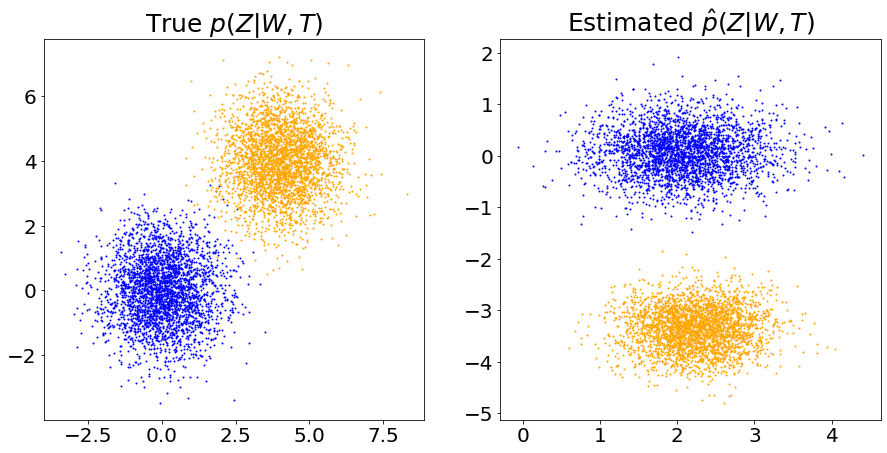

In [5]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|W,T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|W,T)$", size=25)
plt.savefig('./Figures/case_b_lr.png', dpi=1200)

#### 2.1.1 How does the reconstructed $X$ look like?

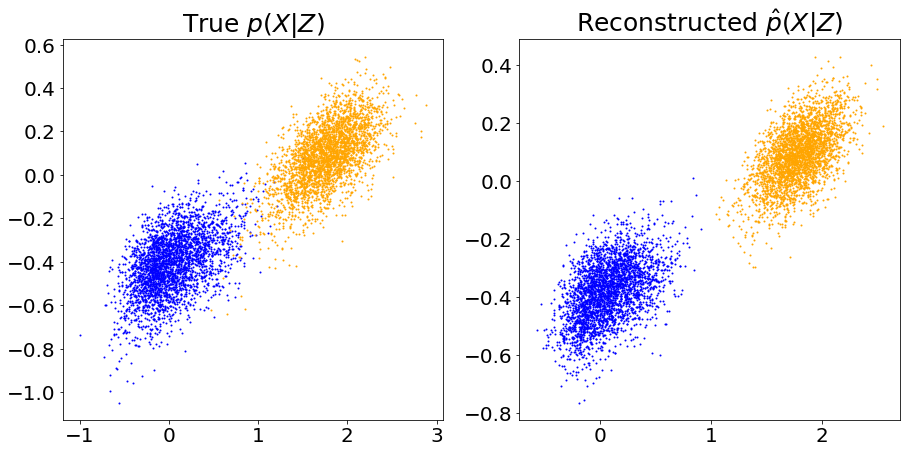

In [6]:
# Only plot the first 2 dimensions of X for better visualization
with torch.no_grad():
    x_m = imavae.ivae.decoder_dist.sample(*imavae.ivae.decoder_params(z_m))

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(X[i,0], X[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(x_m[i,0], x_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(X|Z)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Reconstructed $\hat{p}(X|Z)$", size=25)
plt.savefig('./Figures/case_b_recon.png', dpi=1200)

### 2.2 What if we use a multi-layer perception for $g_{\boldsymbol{\gamma}}$ ?

In [7]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=1,
                n_sup_hidden_dim=20, optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 199, Best Recon MSE: 0.0101789, Best Pred Metric [0.0702


Saving the last epoch with training MSE: 0.0101789 and Pred Metric: [0.07020298, 0.07020298]
Loaded the best model from Epoch: 199 with MSE: 0.0101789 and Pred Metric: [0.07020298, 0.07020298]
ACME (control) = 4.6322 +/- 0.0112
ACME (treatment) = 4.2884 +/- 0.0120
ADE (control) = -1.3276 +/- 0.0054
ADE (treatment) = -1.6699 +/- 0.0032
ATE = 2.9609 +/- 0.0103
-------------------------------------
ACME err (control) = 0.3331 +/- 0.0112
ACME err (treatment) = 0.0107 +/- 0.0120
ADE err (control) = 0.0369 +/- 0.0054
ADE err (treatment) = 0.3792 +/- 0.0032
ATE err = 0.0476 +/- 0.0103


Text(0.5, 1.0, 'Estimated $\\hat{p}(Z|W,T)$')

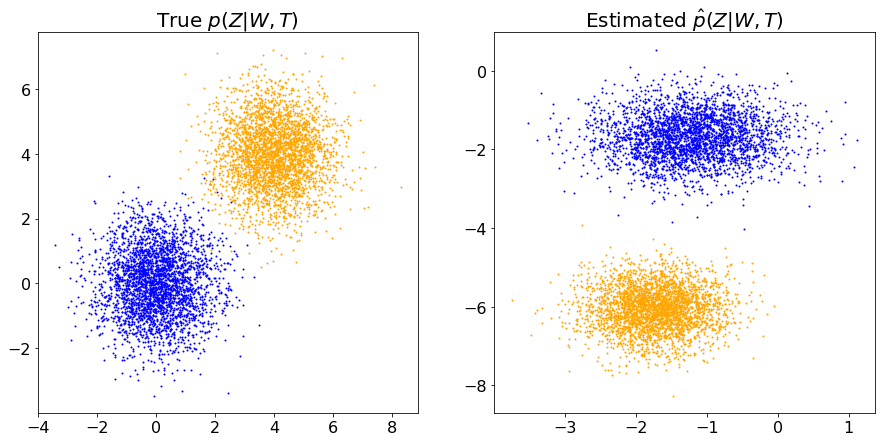

In [8]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].set_title("True $p(Z|W,T)$", size=20)
axs[1].set_title("Estimated $\hat{p}(Z|W,T)$", size=20)

#### 2.2.1 What if we increase the number of parameters of the MLP for $g_{\boldsymbol{\gamma}}$?

In [9]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=2,
                n_sup_hidden_dim=20, optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 198, Best Recon MSE: 0.0103577, Best Pred Metric [0.0683


Saving the last epoch with training MSE: 0.0103507 and Pred Metric: [0.071961015, 0.071961015]
Loaded the best model from Epoch: 198 with MSE: 0.0103577 and Pred Metric: [0.06835734, 0.06835734]
ACME (control) = 5.1087 +/- 0.0129
ACME (treatment) = 4.0411 +/- 0.0146
ADE (control) = -1.0989 +/- 0.0133
ADE (treatment) = -2.1650 +/- 0.0021
ATE = 2.9441 +/- 0.0119
-------------------------------------
ACME err (control) = 0.8097 +/- 0.0129
ACME err (treatment) = 0.2580 +/- 0.0146
ADE err (control) = 0.1918 +/- 0.0133
ADE err (treatment) = 0.8744 +/- 0.0021
ATE err = 0.0643 +/- 0.0119


In [10]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=3,
                n_sup_hidden_dim=20, optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 197, Best Recon MSE: 0.0101632, Best Pred Metric [0.5702


Saving the last epoch with training MSE: 0.0101475 and Pred Metric: [0.6860213, 0.6860213]
Loaded the best model from Epoch: 197 with MSE: 0.0101632 and Pred Metric: [0.57027465, 0.57027465]
ACME (control) = 4.6052 +/- 0.0134
ACME (treatment) = 4.5599 +/- 0.0148
ADE (control) = -1.5370 +/- 0.0103
ADE (treatment) = -1.5813 +/- 0.0007
ATE = 3.0247 +/- 0.0142
-------------------------------------
ACME err (control) = 0.3061 +/- 0.0134
ACME err (treatment) = 0.2608 +/- 0.0148
ADE err (control) = 0.2464 +/- 0.0103
ADE err (treatment) = 0.2907 +/- 0.0007
ATE err = 0.0162 +/- 0.0142


### 2.3 What if we get rid of the reconstruction term?

In [11]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=-1., elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 176, Best Recon MSE: 0.0100221, Best Pred Metric [0.6289


Saving the last epoch with training MSE: 0.00997938 and Pred Metric: [0.630672, 0.630672]
Loaded the best model from Epoch: 176 with MSE: 0.0100221 and Pred Metric: [0.62895614, 0.62895614]
ACME (control) = 4.1823 +/- 0.0109
ACME (treatment) = 4.1822 +/- 0.0101
ADE (control) = -1.1988 +/- 0.0000
ADE (treatment) = -1.1988 +/- 0.0000
ATE = 2.9838 +/- 0.0095
-------------------------------------
ACME err (control) = 0.1168 +/- 0.0109
ACME err (treatment) = 0.1169 +/- 0.0101
ADE err (control) = 0.0919 +/- 0.0000
ADE err (treatment) = 0.0919 +/- 0.0000
ATE err = 0.0246 +/- 0.0095


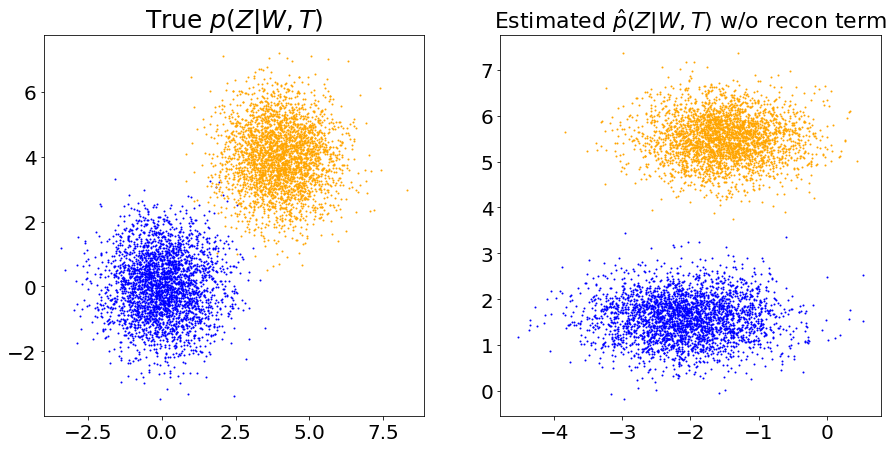

In [12]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|W,T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|W,T)$ w/o recon term", size=22)
plt.savefig('./Figures/case_b_lr_wo_recon.png', dpi=1200)

### 2.4 What if we get rid of the ELBO term?

In [13]:
# Loss converges at epoch 80 but will break down if keeps training with elbo_weight = 0
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=1., elbo_weight=0., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=80, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.0295662, Best Pred Metric [0.014387


Saving the last epoch with training MSE: 0.0295662 and Pred Metric: [0.014387458, 0.014387458]
Loaded the best model from Epoch: 79 with MSE: 0.0295662 and Pred Metric: [0.014387458, 0.014387458]
ACME (control) = -0.0084 +/- 0.0324
ACME (treatment) = -0.0092 +/- 0.0318
ADE (control) = 0.8703 +/- 0.0000
ADE (treatment) = 0.8703 +/- 0.0000
ATE = 0.8637 +/- 0.0280
-------------------------------------
ACME err (control) = 4.3075 +/- 0.0324
ACME err (treatment) = 4.3083 +/- 0.0318
ADE err (control) = 2.1609 +/- 0.0000
ADE err (treatment) = 2.1609 +/- 0.0000
ATE err = 2.1447 +/- 0.0280


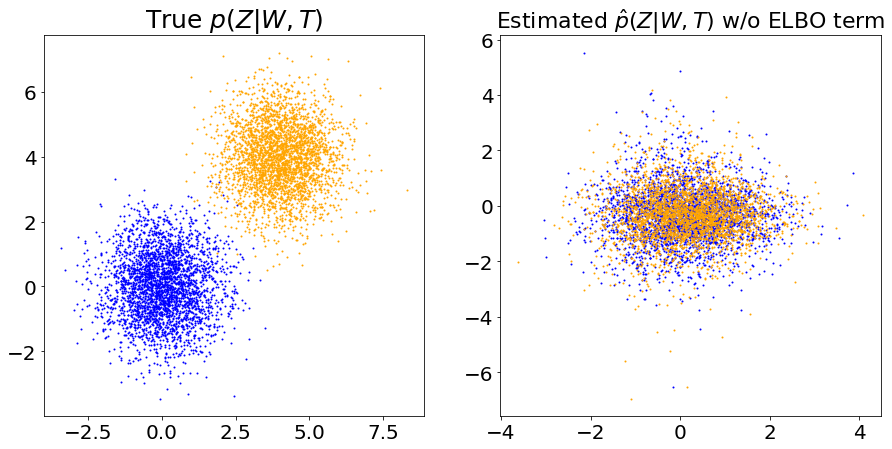

In [14]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|W,T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|W,T)$ w/o ELBO term", size=22)
plt.savefig('./Figures/case_b_lr_wo_elbo.png', dpi=1200)